# Notebook to open and view detections on audio:

## 1) Figuring out our imports:

### a) Below are the imports pertaining to accessing data and metadata

In [1]:
from pathlib import Path
import glob
import exiftool
import soundfile as sf

### b) Below are the imports pertaining to data manipulation

In [2]:
import numpy as np
import pandas as pd
import dask.dataframe as dd

### c) Below are the imports pertaining to data visualization

In [3]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import colors
import datetime as dt

### d) Below are the imports pertaining to the use of the MSDS pipeline

In [4]:
import sys

# append the path of the
# parent directory
sys.path.append('..')
sys.path.append('../src/')
sys.path.append('../src/models/bat_call_detector/batdetect2/')

import src.batdt2_pipeline as batdetect2_pipeline
import src.file_dealer as file_dealer
from cfg import get_config

In [5]:
input_files = sorted(glob.glob('../../Documents/recover-20230809/UBNA_015/*.WAV', recursive=True))
plot_file = input_files[16]
file_dt = dt.datetime.strptime(Path(plot_file).name, "%Y%m%d_%H%M%S.WAV")
plot_file

'../../Documents/recover-20230809/UBNA_015/20230802_110000.WAV'

In [6]:
batdetect2_predictions = pd.read_csv('../output_dir/recover-20230809/E18 Bridge/bd2__recover-20230809_UBNA_015.csv')
file_cond = pd.to_datetime(batdetect2_predictions['input_file'], format="%Y%m%d_%H%M%S", exact=False) == dt.datetime.strptime(Path(plot_file).name, "%Y%m%d_%H%M%S.WAV")
file_dets = batdetect2_predictions.loc[file_cond]
file_dets

,start_time,end_time,low_freq,high_freq,event,class,class_prob,det_prob,individual,input_file,Recover Folder,SD Card,Site name
3341,478.3555,478.3647,26328.0,33930.0,Echolocation,Eptesicus serotinus,0.300,0.530,-1,/mnt/ubna_data_02/recover-20230809/UBNA_015/20...,recover-20230809,UBNA_015,E18 Bridge
3342,478.4915,478.5009,26328.0,34460.0,Echolocation,Eptesicus serotinus,0.306,0.626,-1,/mnt/ubna_data_02/recover-20230809/UBNA_015/20...,recover-20230809,UBNA_015,E18 Bridge
3343,478.7275,478.7385,25468.0,34201.0,Echolocation,Nyctalus leisleri,0.389,0.703,-1,/mnt/ubna_data_02/recover-20230809/UBNA_015/20...,recover-20230809,UBNA_015,E18 Bridge
3344,478.9695,478.9816,25468.0,35930.0,Echolocation,Eptesicus serotinus,0.382,0.608,-1,/mnt/ubna_data_02/recover-20230809/UBNA_015/20...,recover-20230809,UBNA_015,E18 Bridge
3345,479.2135,479.2286,24609.0,33170.0,Echolocation,Nyctalus leisleri,0.269,0.579,-1,/mnt/ubna_data_02/recover-20230809/UBNA_015/20...,recover-20230809,UBNA_015,E18 Bridge
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4011,955.9255,955.9335,41796.0,63344.0,Echolocation,Pipistrellus nathusii,0.445,0.545,-1,/mnt/ubna_data_02/recover-20230809/UBNA_015/20...,recover-20230809,UBNA_015,E18 Bridge
4012,956.0185,956.0273,40937.0,63306.0,Echolocation,Pipistrellus nathusii,0.464,0.588,-1,/mnt/ubna_data_02/recover-20230809/UBNA_015/20...,recover-20230809,UBNA_015,E18 Bridge
4013,956.1145,956.1211,40937.0,55659.0,Echolocation,Pipistrellus nathusii,0.446,0.546,-1,/mnt/ubna_data_02/recover-20230809/UBNA_015/20...,recover-20230809,UBNA_015,E18 Bridge
4014,956.4005,956.4116,40937.0,61696.0,Echolocation,Pipistrellus nathusii,0.408,0.513,-1,/mnt/ubna_data_02/recover-20230809/UBNA_015/20...,recover-20230809,UBNA_015,E18 Bridge


In [7]:
def plot_audio_seg(audio_features, spec_features):
    audio_seg = audio_features['audio_seg']
    fs = audio_features['sample_rate']
    start = audio_features['start']
    duration = audio_features['duration']

    vmin = spec_features['vmin']
    cmap = spec_features['cmap']
    nfft = spec_features['NFFT']

    plt.figure(figsize=(15, 5))
    plt.rcParams.update({'font.size': 24})
    plt.title(f"Spectrogram of file from E-18 Bridge: {Path(plot_file).name}")
    plt.specgram(audio_seg, NFFT=nfft, cmap=cmap, vmin=vmin)
    plt.yticks(ticks=np.linspace(0, 1, 6), labels=np.linspace(0, fs/2000, 6).astype('int'))
    plt.xticks(ticks=np.linspace(0, duration*(fs/2), 11), labels=np.round(np.linspace(start, start+duration, 11, dtype='float'), 2))
    plt.ylabel("Frequency (kHz)")
    plt.xlabel("Time (s)")
    plt.show()


def plot_dets_over_audio(audio_features, spec_features, file_dets):
    audio_seg = audio_features['audio_seg']
    fs = audio_features['sample_rate']
    start = audio_features['start']
    duration = audio_features['duration']

    vmin = spec_features['vmin']
    cmap = spec_features['cmap']
    nfft = spec_features['NFFT']

    plt.figure(figsize=(15, 5))
    plt.title(f"BatDetect2 Detections on E-18 Bridge: {Path(plot_file).name}")
    plt.specgram(audio_seg, NFFT=nfft, cmap=cmap, vmin=vmin)
    window_cond = np.logical_and(file_dets['start_time'] > start, file_dets['end_time'] < (start+duration))
    plot_dets = file_dets.loc[window_cond]

    ax = plt.gca()
    for i, row in plot_dets.iterrows():
        rect = patches.Rectangle(((row['start_time'] - start)*(fs/2), row['low_freq']/(fs/2)), 
                        (row['end_time'] - row['start_time'])*(fs/2), (row['high_freq'] - row['low_freq'])/(fs/2), 
                        linewidth=2, edgecolor='yellow', facecolor='none', alpha=0.8)
        ax.add_patch(rect)

    plt.yticks(ticks=np.linspace(0, 1, 6), labels=np.linspace(0, fs/2000, 6).astype('int'))
    plt.xticks(ticks=np.linspace(0, duration*(fs/2), 11), labels=np.round(np.linspace(start, start+duration, 11, dtype='float'), 2))
    plt.ylabel("Frequency (kHz)")
    plt.xlabel("Time (s)")
    plt.show()

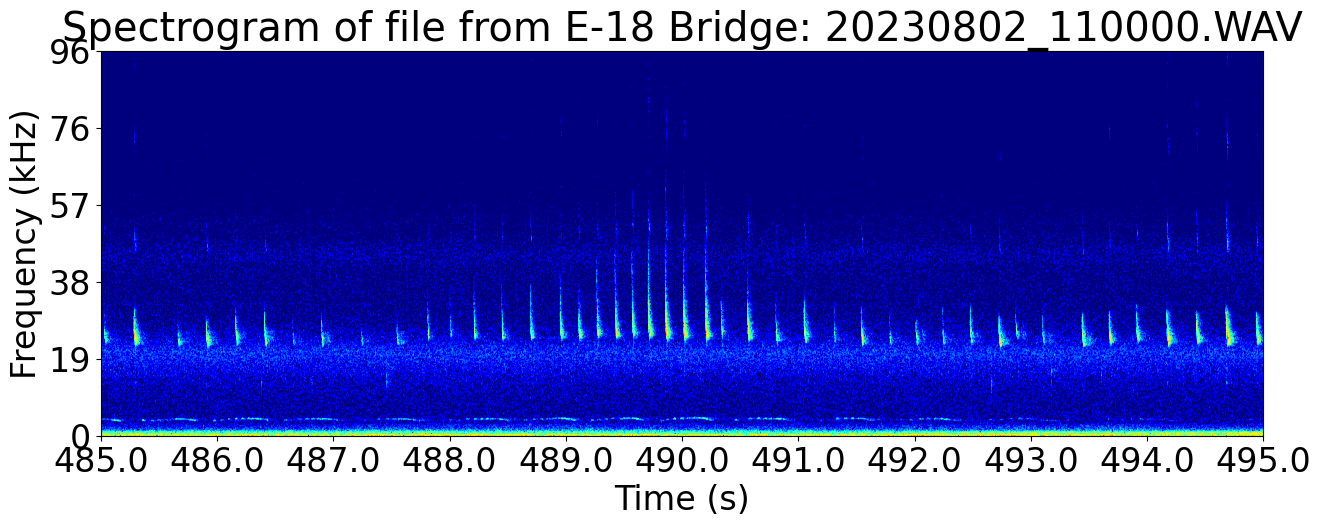

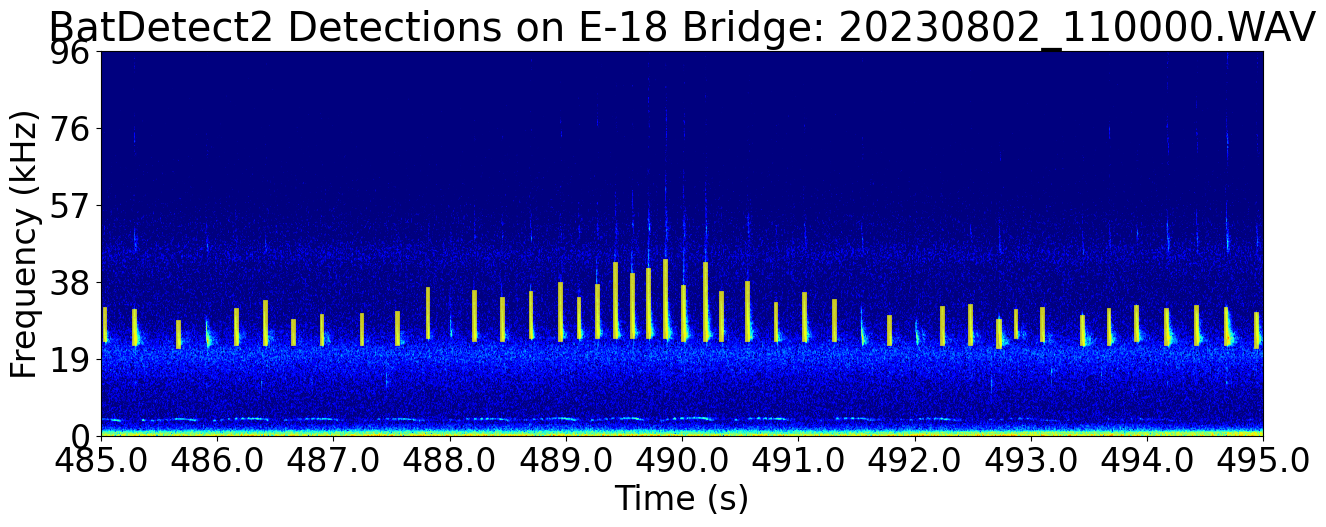

In [10]:
audio_file = sf.SoundFile(plot_file)
fs = audio_file.samplerate
start = 485
duration = 10
audio_file.seek(int(fs*start))
audio_seg = audio_file.read(int(fs*duration))
vmin = 20*np.log10(np.max(audio_seg)) - 45 # hide anything below -rm_dB dB

audio_features = dict()
audio_features['audio_seg'] = audio_seg
audio_features['sample_rate'] = fs
audio_features['start'] = start
audio_features['duration'] = duration

spec_features = dict()
spec_features['NFFT'] = 1024
spec_features['cmap'] = 'jet'
spec_features['vmin'] = vmin

plot_audio_seg(audio_features, spec_features)

plot_dets_over_audio(audio_features, spec_features, file_dets)